In [1]:
import os
from openimages.download import download_dataset

In [211]:
data_dir = "train"
number_for_samples = 2000
classes = ["Person", "Dog", "Cat"]
classes_dict = {"person": 0, "dog": 1, "cat": 2}

In [212]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [213]:
print("Downloading is starting...")

download_dataset(data_dir, classes, limit=number_for_samples, annotation_format="pascal")

2023-04-11  22:46:15 INFO Downloading 2000 train images for class 'person'
100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [01:14<00:00, 27.01it/s]
2023-04-11  22:47:29 INFO Creating 2000 train annotations (pascal) for class 'person'
100%|████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1725.19it/s]
2023-04-11  22:47:31 INFO Downloading 2000 train images for class 'dog'
100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.07it/s]
2023-04-11  22:48:45 INFO Creating 2000 train annotations (pascal) for class 'dog'
100%|████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 8186.70it/s]
2023-04-11  22:48:47 INFO Downloading 2000 train images for class 'cat'
100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.61it/s]
2023-04-11  22:49:59 INFO Creating 2000 train annota

{'person': {'images_dir': 'train/person/images',
  'annotations_dir': 'train/person/pascal'},
 'dog': {'images_dir': 'train/dog/images',
  'annotations_dir': 'train/dog/pascal'},
 'cat': {'images_dir': 'train/cat/images',
  'annotations_dir': 'train/cat/pascal'}}

In [230]:
import torch
import torchvision
from torch.autograd import Variable

In [231]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [232]:
transform = transforms.Compose([          
    transforms.Resize(256),                   
    transforms.CenterCrop(224),                
    transforms.ToTensor(),                     
    transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])

transform_viz = transforms.Compose([           
    transforms.ToTensor(),                     
    ])

In [217]:
def read_img(file_name, train=True, add_dim=False):
    img = Image.open(file_name).convert("RGB")
    if train:
        img_t = transform(img)
    else:
        img_t = transform_viz(img)
    if add_dim:
        img_t = torch.unsqueeze(img_t, 0)
    return img_t

In [218]:
import glob2
import xml.etree.ElementTree as ET
import numpy as np
import torch
import torch.nn.functional as F

In [219]:
def load_meta_data(folder):
    return glob2.glob("{}/*/pascal/*xml".format(folder))

In [281]:
def get_values(data, indexes, class_min):
    return [data[index] for index in indexes[0:class_min]]

def get_data(folder):
    meta_data_files = load_meta_data(folder)
    files = []
    values = []

    for i, meta_file in enumerate(meta_data_files):
        tree = ET.parse(meta_file)
        root = tree.getroot()
        file_path = root.find('path').text

        if len(root.findall('object')) == 1:
            obj = root.findall('object')[0]
            label = obj.find('name').text
            values.append(classes_dict[label])
            files.append(file_path)
            
    class_counts = np.bincount(np.array(values))
    class_min = min(class_counts)
    
    first_class = [i for i, x in enumerate(values) if x == 0]
    second_class = [i for i, x in enumerate(values) if x == 1]
    third_class = [i for i, x in enumerate(values) if x == 2]
    X_balanced = get_values(files, first_class, class_min) + get_values(files, second_class, class_min) + get_values(files, third_class, class_min)
    
    Y_balanced = get_values(values, first_class, class_min) + get_values(values, second_class, class_min) + get_values(values, third_class, class_min)
    
    return X_balanced, Y_balanced


In [282]:
X_train, Y_train = get_data('train')

In [290]:
class_counts = np.bincount(np.array(Y_train))

# Print the class counts
for i, count in enumerate(class_counts):
    print("Class {}: Count = {}".format(i, count))

Class 0: Count = 1121
Class 1: Count = 1121
Class 2: Count = 1121


In [292]:
Y = torch.tensor(Y_train)
Y = F.one_hot(Y, num_classes=3)
Y.shape, Y

(torch.Size([3363, 3]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1]]))

In [293]:
class MultiTaskDataset(Dataset):
    def __init__(self, files, y):
        self.y = y
        self.files = files

    def __len__(self): return len(self.files)

    def __getitem__(self, index):
        image_file = self.files[index]
        img = read_img(image_file)
        
        y = self.y[index]
        
        return img, (y)

In [302]:
custom_dataset = MultiTaskDataset(X_train, Y)

In [303]:
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=8, shuffle=True)

## Training a single-label model

In [166]:
import torch
from torch.autograd import Variable
from torchvision import models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [353]:
# model creation
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # set the number of outputs
        self.new_number_of_cls_output = 3
        self.new_number_of_reg_output = 3
        
        # our pre-trained model
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.dropout = nn.Dropout(0.1)
        self.model.fc_single = nn.Linear(512, self.new_number_of_cls_output)
        self.model.fc_multi = nn.Linear(512, self.new_number_of_cls_output)
        for param in self.model.fc_single.parameters():
            param.requires_grad = True
        
        for param in self.model.fc_multi.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.model.conv1(x)#image
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.dropout(x)
        
        y_1 = self.model.fc_single(x) 
        y_1 = F.softmax(y_1, dim=1) #single label
        y_2 = self.model.fc_multi(x) 
        y_2 = F.sigmoid(y_2) #multi label
        
        return y_1, y_2

In [354]:
model = Model()

In [355]:
lr = 0.005
loss_cls = nn.CrossEntropyLoss()
loss_reg = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [356]:
epoch_loss = []
epoch_loss_1 = []
epoch_loss_2 = []
epochs = []

In [357]:
for epoch in range(10):  
    running_loss = 0.0
    running_loss_1 = 0.0
    running_loss_2 = 0.0
    correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.float())

        loss = 0
        loss_1 = loss_cls(outputs[0].float(), labels.float())
        loss_2 = loss_cls(outputs[1].float(), labels.float())
        loss = loss_1 + loss_2

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()
        

    print(f'[ep: {epoch + 1}] loss: {running_loss / 2000:.3f}, l1: {running_loss_1 / 2000:.3f}, l2: {running_loss_2 / 2000:.3f}')
    epoch_loss.append(running_loss)
    epoch_loss_1.append(running_loss_1)
    epoch_loss_2.append(running_loss_2)
    epochs.append(epoch)

    

print('Estimation done')


KeyboardInterrupt: 

In [340]:
torch.save(model.state_dict(), 'task1_params_cfb.pth')

In [ ]:
#model_path = "model_params_multilable.pth" #if using ["Clothing", "Mammal", "Bird"]
#model_path = "model_params_mwf.pth" #if using ['Man', 'Widnow', 'Flower']
saved_state_dict = torch.load('task1_params_cfb.pth')
model.load_state_dict(saved_state_dict)

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure()
ax=fig.add_subplot(111, label="1")

ax.plot(epochs, epoch_loss, '-+', color="C0", label='loss (ep)')
ax.set_xlabel("epochs", color="C0")
ax.set_ylim(1e-1, 1e9)
ax.set_yscale('log')


ax.plot(epochs, epoch_loss_1, '-+', color="blue", label='loss (ep)')

ax.plot(epochs, epoch_loss_2, '-+', color="green", label='loss (ep)')

plt.show()

## Testing

[0.11895487 0.20704606 0.673999  ]
[0.09923063 0.31612197 0.5846474 ]
[0.10029895 0.42065826 0.47904277]
[0.11800651 0.2920489  0.5899446 ]
[0.13540003 0.46897718 0.39562273]
[0.13786158 0.28115875 0.58097965]


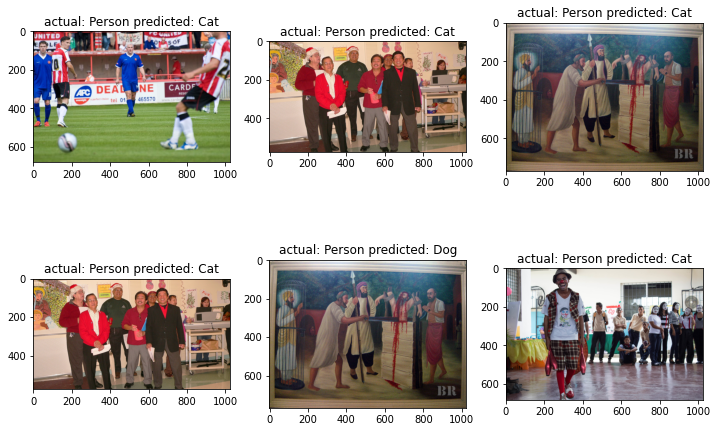

In [345]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
X_test, Y_test = get_data('test')

for i in range(2):
    for j in range(3):
        x = read_img(X_test[i + j], True, True)
        predict = model(x)
        p = predict[0].detach().numpy()[0]
        print(p)
        img = read_img(X_test[i + j], False)
        rgb_img = img.permute(1, 2, 0)
        
        ax[i,j].imshow(rgb_img)
        ax[i,j].set_title('actual: ' + classes[Y_true[i]] + ' predicted: ' + classes[np.argmax(p)])
        #single label prediction


In [346]:
def plot_img(file):
    img = read_img(file, False)
    rgb_img = img.permute(1, 2, 0)
    fig, ax = plt.subplots()
    img = ax.imshow(rgb_img)

In [343]:
single_label_preds = []
multi_label_preds = []

for i, file in enumerate(X_test):
    img = read_img(file, False, True)
    predict = model(img)
    #single label prediction
    p = predict[0].detach().numpy()[0]
    single_label_preds.append((p >= p[np.argmax(p)]).astype(int))
    
    print('predicted:', classes[np.argmax(p)], ', actual:', classes[Y_true[i]])


predicted: Dog , actual: Person
predicted: Cat , actual: Person
predicted: Cat , actual: Person
predicted: Dog , actual: Person
predicted: Cat , actual: Person
predicted: Dog , actual: Person
predicted: Dog , actual: Person
predicted: Dog , actual: Person
predicted: Dog , actual: Person
predicted: Dog , actual: Person
predicted: Cat , actual: Person
predicted: Dog , actual: Person
predicted: Dog , actual: Dog
predicted: Dog , actual: Dog
predicted: Dog , actual: Dog
predicted: Dog , actual: Dog
predicted: Dog , actual: Dog
predicted: Cat , actual: Dog
predicted: Dog , actual: Dog
predicted: Cat , actual: Dog
predicted: Dog , actual: Dog
predicted: Cat , actual: Dog
predicted: Dog , actual: Dog
predicted: Dog , actual: Dog
predicted: Dog , actual: Cat
predicted: Dog , actual: Cat
predicted: Dog , actual: Cat
predicted: Dog , actual: Cat
predicted: Dog , actual: Cat
predicted: Dog , actual: Cat
predicted: Cat , actual: Cat
predicted: Dog , actual: Cat
predicted: Dog , actual: Cat
predict